 ***
   # Les projets réalisés par Agence Française de Développement
 ***
 
 Réalisé par: **Anderson AUGUSMA**
    

***
## Description du projet:
Ce projet est réalisé dans le cadre du cours Scraping et NLP de l'UE datamining du master 2 Econométrie & Statistiques de l'ISFA. Ce cours est enseigné par professeur Aurelien Couloumy. Pour réaliser ce projet, on va recuillir des données sur le site de l'AFD en faisant du scraping. 

### Objectif du projet: 
***
  ####  L'objectif principal de ce projet est de regrouper les différents pays/villes  bénéficiaires en fonction de leurs besoins ou leurs difficultés.
    
***

Pour atteindre cet objectif, on va jouer sur la description des projets réalisées dans chaque pays ainsi que le contexte dans lequel AFD avait jugé nécessaire d'apporter son aide à ce pays. On va proceder par la **"word representation"** pour resumer la description et le context en des mots les plus explicites possibles. Au final si deux ou plusieurs descriptions se ressemblent, cela signifie que la nécéssité était pareille pour la réalisation de ces projets. Ainsi les pays dans lesquels ces projets étaient réalisés avaient la même nécéssité ou mêmes besoins.

### Les Parties du projet
- Ce document aura les parties suivantes:
    - Scraping
    - Nétoyage des données et statistiques descriptives
    - Word representation
    - Classification
        - Clustering
        - Apprentissage supervisé

***

## Librairies nécessaires

In [1]:
# Pour le scraping
import os, requests, bs4, re
import warnings; warnings.filterwarnings("ignore") 
import pandas as pd
from bs4 import BeautifulSoup
from datetime import datetime


In [2]:
# Visualisation
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import seaborn as sns

In [ ]:
# Pour word representation
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.text import TextCollection
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk import pos_tag, pos_tag_sents
from nltk.corpus import stopwords
import collections

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


from langdetect import detect
from langdetect import detect_langs

import spacy
from spacy.lang.fr import French
import fr_core_news_sm


In [ ]:
# Reduction de dimensionnalité 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE 

In [ ]:
# Pour le clustering
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial import distance 

# Pour la normalisation
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer

from sklearn import metrics
from collections import Counter
from sklearn.metrics import confusion_matrix

In [ ]:
# Pour apprentissage supervisé
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.naive_bayes import GaussianNB


from sklearn.metrics import f1_score, classification_report
# Metric f1: Pour avoir un rapport entre la precsion et la sensibilité (Recall) permetant de mesurer les proportions
# d'erreur de type 1 et d'erreur de type2; ie de faux positifs et de faux negatifs.

from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve

## 1- Scraping

In [7]:
#https://www.afd.fr/robots.txt

User-agent: *
 CSS, JS, Images
Allow: /core/*.css$
Allow: /core/*.css?
Allow: /core/*.js$
Allow: /core/*.js?
Allow: /core/*.gif
Allow: /core/*.jpg
Allow: /core/*.jpeg
Allow: /core/*.png
Allow: /core/*.svg
Allow: /profiles/*.css$
Allow: /profiles/*.css?
Allow: /profiles/*.js$
Allow: /profiles/*.js?
Allow: /profiles/*.gif
Allow: /profiles/*.jpg
Allow: /profiles/*.jpeg
Allow: /profiles/*.png
Allow: /profiles/*.svg

In [8]:
web_page_url = "https://www.afd.fr/fr/carte-des-projets"
web_page_response = requests.get(web_page_url)
web_page_response.status_code

200

In [9]:
contenu = bs4.BeautifulSoup(web_page_response.content)

### On veut recuperer: 

- Nom des villes/pays (lieu de réalisation)
- Date de debut du projet
- date de fin des projets
- Description du projet
- Durée des projets
- Secteurs
- Outils de financement
- Montant de financemennt
- Libellé du projet

In [10]:
# On recupere le lien vers les projets à partir de cette balise "div"
div=contenu.find(name="div",class_="block block-ct-search-page block-search-project-viewmode-block")
balise_a = div.findAll(name="a")
a=balise_a[2] # On garde que le troisieme lien
lien_projets=a["href"]
lien_complet="http://www.afd.fr/fr"+lien_projets

In [11]:
# On recupere le contenu de la page projets
web_page_projet = requests.get(lien_complet)
web_page_projet.status_code

200

In [12]:
contenu_projet=bs4.BeautifulSoup(web_page_projet.content)

In [13]:
select_option_page=contenu_projet.findAll(name="option")
lien_page_64=(select_option_page[5])["value"]
lien_projets_64="https://www.afd.fr/fr"+lien_page_64

In [14]:
# On recupere le contenu de la page projets par 64 projets
web_page_projet_64 = requests.get(lien_projets_64)
web_page_projet_64.status_code

200

***
En parcourant le site AFD, on constate que les projets se repartissent en plusieurs pages soit **25** si on les affiches **64** par page. Ainsi pour recuperer les données de toutes ces pages on va constuire un tableau **"All_link_page"** qui reçoit tous les liens correspondants. Pour ce faire, on va jouer sur le premier l'url de la page active en modifiant **"0&sort"** et en y ajoutant **64** à chaque fois. 
***

In [15]:
All_link_page=[]

In [16]:
All_link_page.append(lien_projets_64)

In [17]:
def modif_lien(lien):
    lien = lien.replace('0&sort',mot)
    All_link_page.append(lien)

In [18]:
page_number=0
for i in range(24):
    page_number=page_number+64
    page_number_str=str(page_number)
    mot=page_number_str+'&sort'
    modif_lien(lien_projets_64)   

In [19]:
# On place les données reçcus dans des tableaux
url=[]
title=[]
description=[]
date_start=[]
date_end=[]
duration=[]
secteur=[]
lieu=[]
type_finance=[]
finance_prog=[]
finance=[]
cofinanced=[]

***
On a remarqué à chaque page les projet se divisent en deux groupes dans une balise "div" avec class "odd" et une autre class "even". Ainsi on recupere les données avec les deux scripts suivants:
***

In [21]:
# On recupere les liens des projets dans la classe _odd  de "div".
# On recupere le contenu de la page projets par 64 projets
for lien_page in All_link_page: 
    par_page_projet = requests.get(lien_page)
    contenu_projet_page=bs4.BeautifulSoup(par_page_projet.content)
    contenu_p1=contenu_projet_page.find(name="div", class_="ctsearch-result-list tile") #contenue d'une page des projets
            
    # On recupere les liens des projets dans la classe _odd  de "div".

    contenu_odd=contenu_p1.findAll(name="div", class_="ctsearch-result-item odd")

        # On recupere les liens des projets dans la classe _odd  de "div".
    for odd in contenu_odd:
        titre_projet=odd.find(name="h3").get_text()
        title.append(titre_projet)
        a_odd=odd.find(name="a")
        lien_odd=a_odd["href"]
        lien_odd_projet="http://www.afd.fr"+lien_odd
        url.append(lien_odd_projet)


        page_projet_odd = requests.get(lien_odd_projet)
        page_projet_odd.status_code 
        #Le contenu de la page projet
        contenu_projet_odd = bs4.BeautifulSoup(page_projet_odd.content)

        # Date de debut
        date_debut_odd=contenu_projet_odd.find(name="div",class_="date start")
        if date_debut_odd==None:
            date_debut_odd_1="NAN"
            date_start.append(date_debut_odd_1)
        else:
            date_debut_odd_1=(date_debut_odd.find(name="div", class_="value")).get_text()
            date_start.append(date_debut_odd_1)

        # On recupere la date de fin du projet
        date_fin_odd=contenu_projet_odd.find(name="div",class_="date end")
        if date_fin_odd==None:
            date_fin_odd_1="NAN"
            date_end.append(date_fin_odd_1)
        else:
            date_fin_odd_1=(date_debut_odd.find(name="div", class_="value")).get_text()
            date_end.append(date_fin_odd_1)

        # La durée du projet
        dure_odd=contenu_projet_odd.find(name="div",class_="funding-duration")
        if dure_odd==None:
            dure_odd_1="NAN"
            duration.append(dure_odd_1)
        else:
            dure_odd_1=(dure_odd.find(name="div", class_="value")).get_text()
            duration.append(dure_odd_1)

        # On recupere le texte de la description et le contexte du projet
        descriptif_odd=contenu_projet_odd.find(name="div", class_="clearfix text-formatted field field--name-field-descriptive-nm field--type-text-long field--label-hidden field__item")
        if descriptif_odd==None:
            descriptif_odd_1="NAN"
            description.append(descriptif)
        else:
            descriptif=descriptif_odd.get_text()
            description.append(descriptif)

        # Secteur d'activités
        secteur_odd=contenu_projet_odd.find(name="div",class_="sector")
        if secteur_odd==None:
            secteur_odd_1="NAN"
            secteur.append(secteur_odd_1)
        else:
            secteur_odd_1=(secteur_odd.find(name="div", class_="value")).get_text()
            secteur.append(secteur_odd_1)

        # Lieu de réalisation (localisation)
        lieu_odd=contenu_projet_odd.find(name="div",class_="city")
        if lieu_odd==None:
            lieu_odd_1="NAN"
            lieu.append(lieu_odd_1)
        else:
            lieu_odd_1=(lieu_odd.find(name="div", class_="value")).get_text()
            lieu.append(lieu_odd_1)


        # Outils de financement 
        outil_odd=contenu_projet_odd.find(name="div",class_="funding-type")
        if outil_odd==None:
            outil_odd_1="NAN"
            type_finance.append(outil_odd_1)
        else:
            outil_odd_1=(outil_odd.find(name="div", class_="value")).get_text()
            type_finance.append(outil_odd_1)

        # Programme de financement 
        prog_odd=contenu_projet_odd.find(name="div",class_="funding-program")
        if prog_odd==None:
            prog_odd_1="NAN"
            finance_prog.append(prog_odd_1)
        else:
            prog_odd_1=(prog_odd.find(name="div", class_="value")).get_text()
            finance_prog.append(prog_odd_1)

        # Montant du financement
        montant_odd=contenu_projet_odd.find(name="div",class_="funding-amount")
        if montant_odd==None:
            montant_odd_1="NAN"
            finance.append(montant_odd_1)
        else:
            montant_odd_1=(montant_odd.find(name="div", class_="amount")).get_text()
            finance.append(montant_odd_1)


        # Cofinanceurs
        cofin_odd=contenu_projet_odd.find(name="div",class_="cofinanced")
        if cofin_odd==None:
            cofin_odd_1="NAN"
            cofinanced.append(cofin_odd_1)
        else:
            cofin_odd_1=(cofin_odd.find(name="div", class_="value")).get_text()
            cofinanced.append(cofin_odd_1)



In [22]:
# On recupere les liens des projets dans la classe _even de "div".
# On recupere le contenu de la page projets par 64 projets
for lien_page in All_link_page: 
    par_page_projet = requests.get(lien_page)
    contenu_projet_page=bs4.BeautifulSoup(par_page_projet.content)
    contenu_p1=contenu_projet_page.find(name="div", class_="ctsearch-result-list tile") #contenue d'une page des projets

    contenu_even=contenu_p1.findAll(name="div", class_="ctsearch-result-item even")

            # On recupere les données avec la class even de  la balise "div"
            # On recupere les liens des projets dans la classe _even de "div".
    for even in contenu_even:
        titre_projet=even.find(name="h3").get_text()
        title.append(titre_projet)
        a_even=even.find(name="a")
        lien_even=a_even["href"]
        lien_even_projet="http://www.afd.fr"+lien_even
        url.append(lien_even_projet)



        page_projet_even = requests.get(lien_even_projet)
        page_projet_even.status_code 
        #Le contenu de la page projet
        contenu_projet_even = bs4.BeautifulSoup(page_projet_even.content)

        # Date de debut
        date_debut_even=contenu_projet_even.find(name="div",class_="date start")
        if date_debut_even==None:
            date_debut_even_1="NAN"
            date_start.append(date_debut_even_1)
        else:
            date_debut_even_1=(date_debut_even.find(name="div", class_="value")).get_text()
            date_start.append(date_debut_even_1)

        # On recupere la date de fin du projet
        date_fin_even=contenu_projet_even.find(name="div",class_="date end")
        if date_fin_even==None:
            date_fin_even_1="NAN"
            date_end.append(date_fin_even_1)
        else:
            date_fin_even_1=(date_debut_even.find(name="div", class_="value")).get_text()
            date_end.append(date_fin_even_1)

        # La durée du projet
        dure_even=contenu_projet_even.find(name="div",class_="funding-duration")
        if dure_even==None:
            dure_even_1="NAN"
            duration.append(dure_even_1)
        else:
            dure_even_1=(dure_even.find(name="div", class_="value")).get_text()
            duration.append(dure_even_1)

        # On recupere le texte de la description et le contexte du projet
        descriptif_even=contenu_projet_even.find(name="div", class_="clearfix text-formatted field field--name-field-descriptive-nm field--type-text-long field--label-hidden field__item")
        if descriptif_even==None:
            descriptif="NAN"
            description.append(descriptif)
        else:
            descriptif=descriptif_even.get_text()
            description.append(descriptif)

        # Secteur d'activités
        secteur_even=contenu_projet_even.find(name="div",class_="sector")
        if secteur_even==None:
            secteur_even_1="NAN"
            secteur.append(secteur_even_1)
        else:
            secteur_even_1=(secteur_even.find(name="div", class_="value")).get_text()
            secteur.append(secteur_even_1)

        # Lieu de réalisation (localisation)
        lieu_even=contenu_projet_even.find(name="div",class_="city")
        if lieu_even==None:
            lieu_even_1="NAN"
            lieu.append(lieu_even_1)
        else:
            lieu_even_1=(lieu_even.find(name="div", class_="value")).get_text()
            lieu.append(lieu_even_1)


        # Outils de financement 
        outil_even=contenu_projet_even.find(name="div",class_="funding-type")
        if outil_even==None:
            outil_even_1="NAN"
            type_finance.append(outil_even_1)
        else:
            outil_even_1=(outil_even.find(name="div", class_="value")).get_text()
            type_finance.append(outil_even_1)

        # Programme de financement 
        prog_even=contenu_projet_even.find(name="div",class_="funding-program")
        if prog_even==None:
            prog_even_1="NAN"
            finance_prog.append(prog_even_1)
        else:
            prog_even_1=(prog_even.find(name="div", class_="value")).get_text()
            finance_prog.append(prog_even_1)

        # Montant du financement
        montant_even=contenu_projet_even.find(name="div",class_="funding-amount")
        if montant_even==None:
            montant_even_1="NAN"
            finance.append(montant_even_1)
        else:
            montant_even_1=(montant_even.find(name="div", class_="amount")).get_text()
            finance.append(montant_even_1)


        # Cofinanceurs
        cofin_even=contenu_projet_even.find(name="div",class_="cofinanced")
        if cofin_even==None:
            cofin_even_1="NAN"
            cofinanced.append(cofin_even_1)
        else:
            cofin_even_1=(cofin_even.find(name="div", class_="value")).get_text()
            cofinanced.append(cofin_even_1)


In [23]:
pd.set_option('display.max_column', 12) # ce code permet d'afficher toutes les colonnes en entier. 

In [24]:
# On crée un dataFrame avec les tableaux de données recuillies

data = pd.DataFrame({"title" : title,
                    "lieu" : lieu, 
                    "date_start" : date_start, 
                    "date_end" : date_end,
                    "duration" : duration,
                    "description" : description,
                    "secteur" : secteur,
                    "finance" : finance,
                    "type_finance" : type_finance,
                    "finance_prog" : finance_prog,
                    "cofinanced" : cofinanced,
                    "url" : url})

In [26]:
data.head()

title                 lieu  \
0  \n\n                  Un meilleur accès à l'ea...  \nIrbid et Ramtha\n   
1  \n\n                  Rénover l'axe de transpo...           \nDouala\n   
2  \n\n                  AJUSEN : appui à la just...            \nNiger\n   
3  \n\n                  Promouvoir le développem...   \nTahoua, Agadez\n   
4  \n\n                  Développer un transport ...             \nLima\n   

       date_start        date_end   duration  \
0  \n22/12/2016\n  \n22/12/2016\n  \n5 ans\n   
1  \n01/08/2012\n             NAN  \n5 ans\n   
2  \n14/03/2017\n  \n14/03/2017\n  \n4 ans\n   
3  \n14/03/2017\n  \n14/03/2017\n  \n4 ans\n   
4  \n01/01/2015\n             NAN        NAN   

                                         description  \
0  En Jordanie, la pénurie d'eau est un obstacle ...   
1  La crise économique traversée par le Cameroun ...   
2  Le Niger est marqué par une très forte croissa...   
3  Pays sahélien fortement pénalisé par son encla...   
4  Depuis les années 50, Lima a décuplé sa popula...   

                                             secteur  \
0       \n\nEau et assainissement, \nGouvernance\n\n   
1  \n\nMobilités et transports, \nInfrastructures...   
2                                \n\nGouvernance\n\n   
3         \n\nAgriculture et développement rural\n\n   
4  \n\nMobilités et transports, \nInfrastructures...   

                                             finance  \
0  \n                                            ...   
1  \n                                            ...   
2  \n                                            ...   
3  \n                                            ...   
4  \n                                            ...   

                                        type_finance  \
0               \n\nPrêt concessionnel souverain\n\n   
1               \n\nPrêt concessionnel souverain\n\n   
2  \n\nDélégation de fonds de l'Union européenne\n\n   
3               \n\nPrêt concessionnel souverain\n\n   
4           \n\nPrêt non concessionnel souverain\n\n   

                         finance_prog                   cofinanced  \
0  \nFonds Paix et résilience Minka\n  \n L'Union européenne KfW\n   
1                                 NAN                          NAN   
2                                 NAN       \nl'Union européenne\n   
3                                 NAN       \nl'Union européenne\n   
4                                 NAN                          NAN   

                                                 url  
0  http://www.afd.fr/fr/carte-des-projets/un-meil...  
1  http://www.afd.fr/fr/carte-des-projets/renover...  
2  http://www.afd.fr/fr/carte-des-projets/ajusen-...  
3  http://www.afd.fr/fr/carte-des-projets/promouv...  
4  http://www.afd.fr/fr/carte-des-projets/develop...

Pour eviter de trop recharger les données à partir du site AFD à chaque fois, on va enregister le dataset sous format excel en local. La raison est les données sont volumineuses et cela prend beaucoup en execution et pour éviter de depaaser le nombre de tentatives de recupération de données sur le site. 

In [27]:
# On enregistre les données dans un fichier Data_afd.xlsx
# on le met en commantaire pour ne pas le lancer plusieurs fois

#data.to_excel(r'C:\Users\ander\Documents\ISFA_Python\Data_afd.xlsx',index=False, header=True)

In [28]:
# On recharge les données à partir de notre repertoire
data = pd.read_excel('Data_afd.xlsx')

In [29]:
data.shape

(1537, 12)

In [30]:
data.head()

title                 lieu  \
0  \n\n                  Un meilleur accès à l'ea...  \nIrbid et Ramtha\n   
1  \n\n                  Rénover l'axe de transpo...           \nDouala\n   
2  \n\n                  AJUSEN : appui à la just...            \nNiger\n   
3  \n\n                  Promouvoir le développem...   \nTahoua, Agadez\n   
4  \n\n                  Développer un transport ...             \nLima\n   

       date_start        date_end   duration  \
0  \n22/12/2016\n  \n22/12/2016\n  \n5 ans\n   
1  \n01/08/2012\n             NAN  \n5 ans\n   
2  \n14/03/2017\n  \n14/03/2017\n  \n4 ans\n   
3  \n14/03/2017\n  \n14/03/2017\n  \n4 ans\n   
4  \n01/01/2015\n             NAN        NAN   

                                         description  \
0  En Jordanie, la pénurie d'eau est un obstacle ...   
1  La crise économique traversée par le Cameroun ...   
2  Le Niger est marqué par une très forte croissa...   
3  Pays sahélien fortement pénalisé par son encla...   
4  Depuis les années 50, Lima a décuplé sa popula...   

                                             secteur  \
0       \n\nEau et assainissement, \nGouvernance\n\n   
1  \n\nMobilités et transports, \nInfrastructures...   
2                                \n\nGouvernance\n\n   
3         \n\nAgriculture et développement rural\n\n   
4  \n\nMobilités et transports, \nInfrastructures...   

                                             finance  \
0  \n                                            ...   
1  \n                                            ...   
2  \n                                            ...   
3  \n                                            ...   
4  \n                                            ...   

                                        type_finance  \
0               \n\nPrêt concessionnel souverain\n\n   
1               \n\nPrêt concessionnel souverain\n\n   
2  \n\nDélégation de fonds de l'Union européenne\n\n   
3               \n\nPrêt concessionnel souverain\n\n   
4           \n\nPrêt non concessionnel souverain\n\n   

                         finance_prog                   cofinanced  \
0  \nFonds Paix et résilience Minka\n  \n L'Union européenne KfW\n   
1                                 NAN                          NAN   
2                                 NAN       \nl'Union européenne\n   
3                                 NAN       \nl'Union européenne\n   
4                                 NAN                          NAN   

                                                 url  
0  http://www.afd.fr/fr/carte-des-projets/un-meil...  
1  http://www.afd.fr/fr/carte-des-projets/renover...  
2  http://www.afd.fr/fr/carte-des-projets/ajusen-...  
3  http://www.afd.fr/fr/carte-des-projets/promouv...  
4  http://www.afd.fr/fr/carte-des-projets/develop...

## 2- Netoyage et Préparation des données 

In [31]:
# Un aperçu du premier titre
data['title'][0]

"\n\n                  Un meilleur accès à l'eau pour les communautés hôtes et réfugiées du nord\n              \n"

In [32]:
# On enleve les retours à la ligne , les tabulations, les espaces, et les autres caracteres inutiles 
regex = re.compile(r'[\n\r\t]') 
regex2 = re.compile(r'[\n\r\t\s+$]') 

date_start= [regex.sub("", dt) for dt in data["date_start"]]
date_end= [regex.sub("", dt) for dt in data["date_end"]]
title = [regex.sub("", tit) for tit in data["title"]]


title_new=[tit.strip() for tit in title] # On supreime les espaces avant et après le title avec "strip"

lieu = [regex.sub("", index) for index in data["lieu"]]
duration = [regex.sub("", index) for index in data["duration"]]
secteur = [regex.sub("", index) for index in data["secteur"]]
finance = [regex2.sub("", index) for index in data["finance"]]
type_finance = [regex.sub("", index) for index in data["type_finance"]]
finance_prog = [regex.sub("", index) for index in data["finance_prog"]]
cofinanced = [regex.sub("", index) for index in data["cofinanced"]]
description = [regex.sub("", index) for index in data["description"]]


data['date_start'] =  date_start
data['date_end'] =  date_end
data['title'] =  title_new
data['lieu'] =  lieu
data['duration'] =  duration
data['secteur'] =  secteur
data['finance'] =  finance
data['type_finance'] =  type_finance
data['finance_prog'] =  finance_prog
data['cofinanced'] =  cofinanced
data['description'] =  description


data.head()

title             lieu  \
0  Un meilleur accès à l'eau pour les communautés...  Irbid et Ramtha   
1   Rénover l'axe de transport essentiel du Cameroun           Douala   
2  AJUSEN : appui à la justice et à la sécurité a...            Niger   
3  Promouvoir le développement rural grâce à l'ag...   Tahoua, Agadez   
4  Développer un transport public efficace et dur...             Lima   

   date_start    date_end duration  \
0  22/12/2016  22/12/2016    5 ans   
1  01/08/2012         NAN    5 ans   
2  14/03/2017  14/03/2017    4 ans   
3  14/03/2017  14/03/2017    4 ans   
4  01/01/2015         NAN      NAN   

                                         description  \
0  En Jordanie, la pénurie d'eau est un obstacle ...   
1  La crise économique traversée par le Cameroun ...   
2  Le Niger est marqué par une très forte croissa...   
3  Pays sahélien fortement pénalisé par son encla...   
4  Depuis les années 50, Lima a décuplé sa popula...   

                                             secteur    finance  \
0                 Eau et assainissement, Gouvernance   72000000   
1  Mobilités et transports, Infrastructures, Vill...   75000000   
2                                        Gouvernance    6000000   
3                 Agriculture et développement rural   68000000   
4  Mobilités et transports, Infrastructures, Vill...  120500000   

                                type_finance                    finance_prog  \
0               Prêt concessionnel souverain  Fonds Paix et résilience Minka   
1               Prêt concessionnel souverain                             NAN   
2  Délégation de fonds de l'Union européenne                             NAN   
3               Prêt concessionnel souverain                             NAN   
4           Prêt non concessionnel souverain                             NAN   

                cofinanced                                                url  
0   L'Union européenne KfW  http://www.afd.fr/fr/carte-des-projets/un-meil...  
1                      NAN  http://www.afd.fr/fr/carte-des-projets/renover...  
2       l'Union européenne  http://www.afd.fr/fr/carte-des-projets/ajusen-...  
3       l'Union européenne  http://www.afd.fr/fr/carte-des-projets/promouv...  
4                      NAN  http://www.afd.fr/fr/carte-des-projets/develop...

In [33]:
data.describe()

title    lieu date_start  \
count                                                1537    1537       1537   
unique                                               1525     968        753   
top     Favoriser l’adaptation des crédits étudiants a...  France        NAN   
freq                                                    2      30        266   

       date_end duration                                        description  \
count      1537     1537                                               1537   
unique      492       82                                               1522   
top         NAN      NAN  Au Cambodge, l’extension du réseau d’eau et d’...   
freq        891      626                                                  3   

                            secteur finance type_finance finance_prog  \
count                          1537    1537         1537         1537   
unique                          255     691           38            6   
top     Santé et protection sociale     NAN   Subvention          NAN   
freq                            145      60          443         1492   

       cofinanced                                                url  
count        1537                                               1537  
unique        340                                               1537  
top           NAN  http://www.afd.fr/fr/carte-des-projets/promouv...  
freq         1035                                                  1

## Visualisation

- Dans cette partie, on visualise quelques variables permettant d'avaoir une vue d'ensembles sur les projets réalisés par AFD. 
- Cela va permettre de mettre en évidence : Type de financement, les financeurs et co-financeurs, programme de financement, la durées de réalisation ainsi les secteurs d'activités.

#### Visualisation du type de financement 

In [35]:
fig=px.pie(data, names='type_finance')
fig.show()

- On peut voir, à partir de la figure précédente, la majorité de ces projets ont un type de financement 'prèt et 'subvention'.
***
    

#### Visualisation de la durée projets

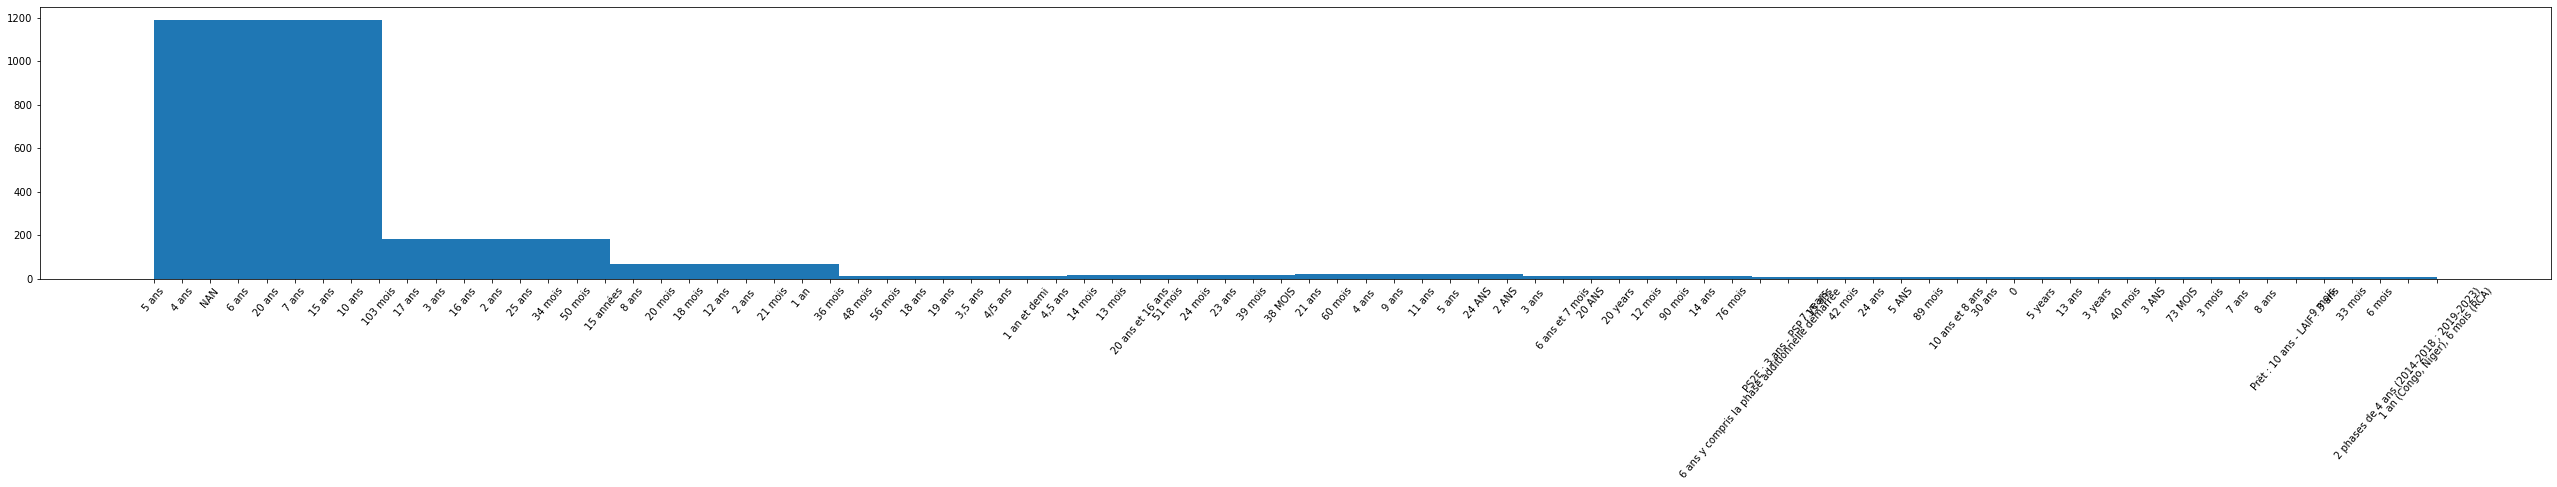

In [36]:
plt.figure(figsize=(45, 5))
plt.hist(data['duration'])
plt.xticks(rotation = 50)
plt.show()

- On peut remarquer, la majortité des projets pour lesquels on dispose de données durent 4, 5, 6, 10, 15 et 20 ans pour les plus pertinents.

#### Visualisation des secteurs d'activités

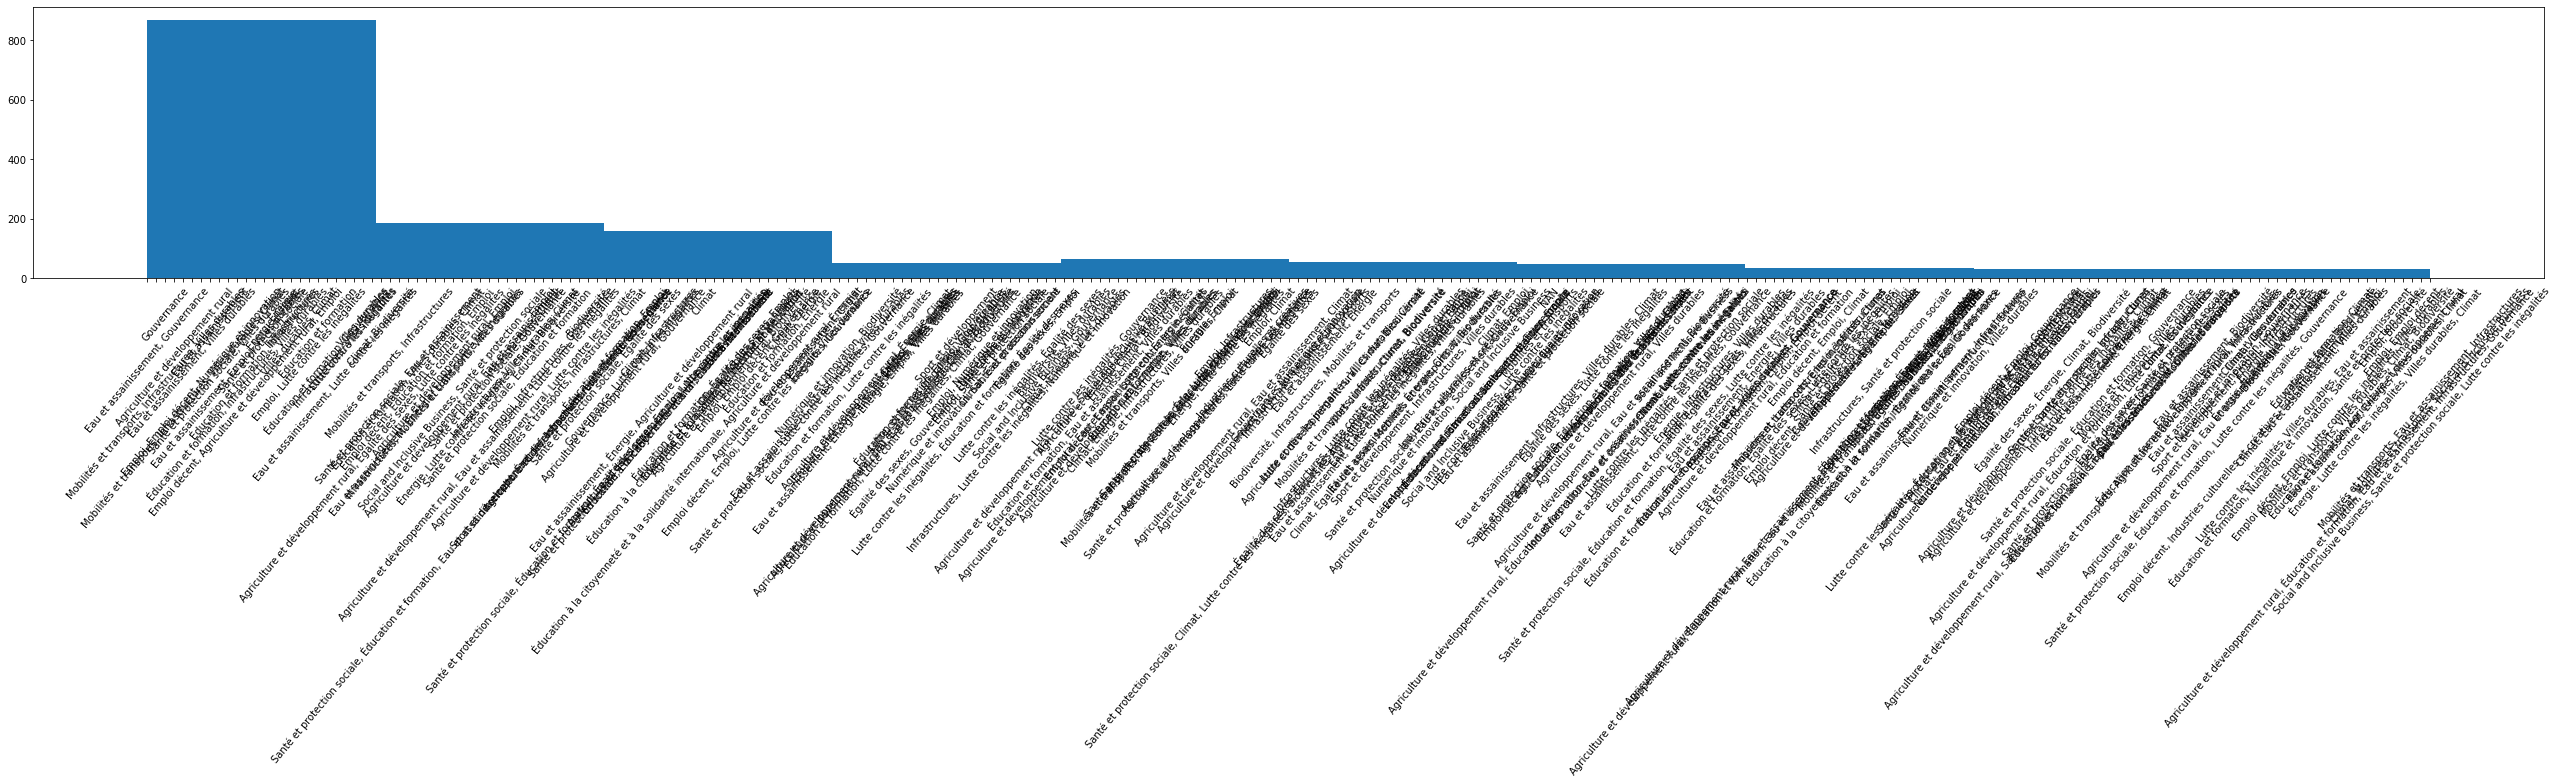

In [37]:
plt.figure(figsize=(45, 5))
plt.hist(data['secteur'])
plt.xticks(rotation = 50)
plt.show()

- **On remarque sur ce graphique, les secteurs d'activités les plus fréquents sont:**
    - Assainissement , Eau
    - Climat
    - Villes durables
    - Emploie, Education et Formation
    - Mobilités et transports
    - infrasturcture.

# 3-Word representation

## Text cleaning process


- Dans cette partie, on va s'interer surtout à la description des projets. On va faire du nétoyage des descriptions pour avoir mots qui s'implifie beaucoup plus la compréhension de la description, et pour  avoir une description la plus rationnelle possible.


- Pour ce la on va appliquer des méthodes de:
    - Tokenization

    - Lowercasing

    - Manage punctions and other related elements

    - Stemming and lemmatization

    - Stop words to delete

    - Control and finalization


#### 1-Text initial
- On commence sur la premiere description de projets.

In [38]:
nlp = fr_core_news_sm.load()

In [39]:
my_desc_1=nlp(data["description"][0])
print(my_desc_1)

En Jordanie, la pénurie d'eau est un obstacle majeur au développement du pays. Dans les gouvernorats du nord, l'eau est principalement alimentée par pompage à partir de sources d'eaux souterraines locales, qui sont utilisées au-delà de leur potentiel de renouvellement durable. La crise syrienne a provoqué un afflux massif de réfugiés, dont la plupart vivent dans cette région. Cette arrivée a considérablement aggravé la situation de surexploitation et a contribué à la détérioration du service. Une situation explosive susceptible de devenir une source de tensions entre les réfugiés et les populations d'accueil. Pour apaiser cette situation, le gouvernement jordanien a pris plusieurs mesures. Il a ainsi prévu d'augmenter la quantité d'eau fournie aux gouvernorats du nord en étendant le projet d'eau Disi qui approvisionne Amman Zarqa (avec le soutien de l'AFD), puis Zaatari plus au nord.Le gouvernement met également en œuvre le projet Wadi Al Arab II (co-financé par l'UE, la BEI et l'AFD) 

####  2- Tokenization


In [40]:
my_desc_1_tokenized = [word.text for word in my_desc_1]
print(my_desc_1_tokenized)

['En', 'Jordanie', ',', 'la', 'pénurie', "d'", 'eau', 'est', 'un', 'obstacle', 'majeur', 'au', 'développement', 'du', 'pays', '.', 'Dans', 'les', 'gouvernorats', 'du', 'nord', ',', "l'", 'eau', 'est', 'principalement', 'alimentée', 'par', 'pompage', 'à', 'partir', 'de', 'sources', "d'", 'eaux', 'souterraines', 'locales', ',', 'qui', 'sont', 'utilisées', 'au-delà', 'de', 'leur', 'potentiel', 'de', 'renouvellement', 'durable', '.', 'La', 'crise', 'syrienne', 'a', 'provoqué', 'un', 'afflux', 'massif', 'de', 'réfugiés', ',', 'dont', 'la', 'plupart', 'vivent', 'dans', 'cette', 'région', '.', 'Cette', 'arrivée', 'a', 'considérablement', 'aggravé', 'la', 'situation', 'de', 'surexploitation', 'et', 'a', 'contribué', 'à', 'la', 'détérioration', 'du', 'service', '.', 'Une', 'situation', 'explosive', '\xa0', 'susceptible', 'de', 'devenir', 'une', 'source', 'de', 'tensions', 'entre', 'les', 'réfugiés', 'et', 'les', 'populations', "d'", 'accueil', '.', 'Pour', 'apaiser', 'cette', 'situation', ',', 

#### 3- Elimination des Ponctuations

In [41]:
my_desc_1_punctuation = [word.text for word in my_desc_1 if word.is_alpha ]
print(my_desc_1_punctuation)

['En', 'Jordanie', 'la', 'pénurie', 'eau', 'est', 'un', 'obstacle', 'majeur', 'au', 'développement', 'du', 'pays', 'Dans', 'les', 'gouvernorats', 'du', 'nord', 'eau', 'est', 'principalement', 'alimentée', 'par', 'pompage', 'à', 'partir', 'de', 'sources', 'eaux', 'souterraines', 'locales', 'qui', 'sont', 'utilisées', 'de', 'leur', 'potentiel', 'de', 'renouvellement', 'durable', 'La', 'crise', 'syrienne', 'a', 'provoqué', 'un', 'afflux', 'massif', 'de', 'réfugiés', 'dont', 'la', 'plupart', 'vivent', 'dans', 'cette', 'région', 'Cette', 'arrivée', 'a', 'considérablement', 'aggravé', 'la', 'situation', 'de', 'surexploitation', 'et', 'a', 'contribué', 'à', 'la', 'détérioration', 'du', 'service', 'Une', 'situation', 'explosive', 'susceptible', 'de', 'devenir', 'une', 'source', 'de', 'tensions', 'entre', 'les', 'réfugiés', 'et', 'les', 'populations', 'accueil', 'Pour', 'apaiser', 'cette', 'situation', 'le', 'gouvernement', 'jordanien', 'a', 'pris', 'plusieurs', 'mesures', 'Il', 'a', 'ainsi', '

#### 4- Lemming and Lowercasing
- Lowercasing est generallement exécute avec le lemming en spcay

In [42]:
my_desc_1_lemmatized = [word.lemma_.lower() for word in my_desc_1 if word.is_alpha ]
print(my_desc_1_lemmatized)

['en', 'jordanie', 'le', 'pénurie', 'eau', 'être', 'un', 'obstacle', 'majeur', 'au', 'développement', 'de', 'pays', 'dans', 'le', 'gouvernorat', 'de', 'nord', 'eau', 'être', 'principalement', 'alimenter', 'par', 'pompage', 'à', 'partir', 'de', 'source', 'eau', 'souterrain', 'local', 'qui', 'être', 'utiliser', 'de', 'leur', 'potentiel', 'de', 'renouvellement', 'durable', 'le', 'crise', 'syrienne', 'avoir', 'provoquer', 'un', 'afflux', 'massif', 'de', 'réfugié', 'dont', 'le', 'plupart', 'vivre', 'dans', 'ce', 'région', 'ce', 'arrivée', 'avoir', 'considérablemer', 'aggraver', 'le', 'situation', 'de', 'surexploitation', 'et', 'avoir', 'contribuer', 'à', 'le', 'détérioration', 'de', 'service', 'un', 'situation', 'explosif', 'susceptible', 'de', 'devenir', 'un', 'source', 'de', 'tension', 'entre', 'le', 'réfugié', 'et', 'le', 'population', 'accueil', 'pour', 'apaiser', 'ce', 'situation', 'le', 'gouvernement', 'jordanien', 'avoir', 'prendre', 'plusieurs', 'mesure', 'il', 'avoir', 'ainsi', 'pr

#### 5- Elimination des stop words

In [43]:
my_desc_1_stpword = [word.lemma_.lower() for word in my_desc_1 if word.is_alpha and not word.is_stop ]
print(my_desc_1_stpword)

['jordanie', 'pénurie', 'eau', 'obstacle', 'majeur', 'développement', 'pays', 'gouvernorat', 'nord', 'eau', 'principalement', 'alimenter', 'pompage', 'partir', 'source', 'eau', 'souterrain', 'local', 'utiliser', 'potentiel', 'renouvellement', 'durable', 'crise', 'syrienne', 'provoquer', 'afflux', 'massif', 'réfugié', 'plupart', 'vivre', 'région', 'arrivée', 'considérablemer', 'aggraver', 'situation', 'surexploitation', 'contribuer', 'détérioration', 'service', 'situation', 'explosif', 'susceptible', 'devenir', 'source', 'tension', 'réfugié', 'population', 'accueil', 'apaiser', 'situation', 'gouvernement', 'jordanien', 'prendre', 'mesure', 'prévoir', 'augmenter', 'quantité', 'eau', 'fournie', 'gouvernorat', 'nord', 'étendre', 'projet', 'eau', 'disi', 'approvisionne', 'amman', 'zarqa', 'soutien', 'afd', 'zaatari', 'nord', 'gouvernement', 'mettre', 'également', 'œuvre', 'projet', 'wadi', 'al', 'arab', 'ii', 'ue', 'bei', 'afd', 'eau', 'prélever', 'canal', 'roi', 'abdallah', 'vallée', 'jour

#### 6- Execution sur toutes les descriptions su dataset

In [44]:
def desc_cleaning(_desc):
    tmp = []
    df_count_token = pd.DataFrame(columns=['Description','Initial','Tokenization','Punctuation','Lemmatization','Stopwords'])
   
    for i in range(0, len(_desc)):
        
        my_desc=nlp(_desc.iloc[i])
        
        # cutting the document into words:
        tmp = [word.text for word in my_desc]
        df_count_token.loc[i, ['Initial']] = len(tmp)
        df_count_token.loc[i, ['Tokenization']] = len(set(tmp))
        
        # remove punctuation:
        tmp = [word.text for word in my_desc if word.is_alpha ]
        df_count_token.loc[i, ['Punctuation']] = len(set(tmp))
        
        # lemmatization:
        tmp = [word.lemma_.lower() for word in my_desc if word.is_alpha ]
        df_count_token.loc[i, ['Lemmatization']] = len(set(tmp))
        
        # stop words:
        tmp = [word.lemma_.lower() for word in my_desc if word.is_alpha and not word.is_stop ]
        df_count_token.loc[i, ['Stopwords']] = len(set(tmp))
       
        # document_rebuilding
        tmp = " ".join(tmp)
        df_count_token.loc[i, ['Description']] = tmp
        
    return df_count_token

In [45]:
_desc=data["description"]
df_count_token=desc_cleaning(_desc)

In [46]:
df_count_token.head()

Description Initial Tokenization  \
0  jordanie pénurie eau obstacle majeur développe...     370          194   
1  crise économique traverser cameroun année fort...     196          130   
2  niger marquer très fort croissance démographiq...     138           98   
3  pays sahélien fortement pénaliser enclavement ...     166          108   
4  année lima décupler population absence quasi t...     180          120   

  Punctuation Lemmatization Stopwords  
0         183           154       123  
1         107            93        67  
2          88            80        65  
3          86            78        55  
4         104            92        67

**Le nouveau dataset precedent contient les nombre de tokens restants pour chaque description après le cleaning.**
***

#### 7- Data visaualisation

In [47]:
fig = go.Figure()
fig.add_trace(go.Box(y=df_count_token["Tokenization"],name="Tokenization"))
fig.add_trace(go.Box(y=df_count_token["Punctuation"],name="Punctuation"))
fig.add_trace(go.Box(y=df_count_token["Lemmatization"],name="Lemmatization"))
fig.add_trace(go.Box(y=df_count_token["Stopwords"],name="Stopwords"))
fig.show()

A partir des boxplots de la figure ci-dessus, on peut voir au niveau des Ttopwords qu'on a pu reduire le nombre de mots à la moitié comparativement au boxplot de Tokenization.
***

***
## Term Document Matrix

- Pour rester dans l'objectif de notre travail qui est de regrouper les projets les plus proches possibles via leurs descriptions, on va jouer sur le "Text cleaning process" en utilisant les resultats des mots restants.

In [48]:
my_text= word_tokenize(df_count_token['Description'].iloc[0], language="french")
text_most_common = collections.Counter(my_text).most_common()

In [49]:
#On visualise les 40 premiers mots les plus communs de la premiere description
fig = px.bar(text_most_common, x=[pair[0] for pair in text_most_common][0:40], y= [pair[1] for pair in text_most_common][0:40])
fig.show()

On peut remarquer que "eau" a la plus grande occurance.
***

In [50]:
vectorizer = CountVectorizer (max_features = 20000)
res_matrix = vectorizer.fit_transform(df_count_token['Description'])
res_matrix

<1537x9326 sparse matrix of type '<class 'numpy.int64'>'
	with 89764 stored elements in Compressed Sparse Row format>

In [51]:
df_skl_tdm_trsf = pd.DataFrame(res_matrix.toarray().transpose(), index = vectorizer.get_feature_names(), columns=data['lieu'])
df_skl_tdm = df_skl_tdm_trsf.transpose()
df_skl_tdm.head()

aa  aammiq  ab  abaisser  abala  abandon  abandonner  \
lieu                                                                    
Irbid et Ramtha   0       0   0         0      0        0           0   
Douala            0       0   0         0      0        0           0   
Niger             0       0   0         0      0        0           0   
Tahoua, Agadez    0       0   0         0      0        0           0   
Lima              0       0   0         0      0        0           0   

                 abastecimento  abatis  abattage  ...  évènement  \
lieu                                              ...              
Irbid et Ramtha              0       0         0  ...          0   
Douala                       0       0         0  ...          0   
Niger                        0       0         0  ...          0   
Tahoua, Agadez               0       0         0  ...          0   
Lima                         0       0         0  ...          0   

                 évènementiell  événement  être  île  îlet  îlot  œuf  œuvre  \
lieu                                                                           
Irbid et Ramtha              0          0     0    0     0     0    0      1   
Douala                       0          0     0    0     0     0    0      0   
Niger                        0          0     0    0     0     0    0      0   
Tahoua, Agadez               0          0     0    0     0     0    0      0   
Lima                         0          0     0    0     0     0    0      0   

                 œuvrer  
lieu                     
Irbid et Ramtha       0  
Douala                0  
Niger                 0  
Tahoua, Agadez        0  
Lima                  0  

[5 rows x 9326 columns]

On a créé un dataframe faisant la somme des occurances des mots pour chaque description de projet correspondant à chaque lieu.
***

***
#### Nettoyage de cette base de données

Pour le nettoyage de ce dataset, on va supprimer toutes les variables dont les valeurs sont nulles partout.  Cela nous permettera d'enlever en grande partie les mots qui sont mal-tokenisés qui n'apparaissent au final ans aucune description. Ainsi on enleve tous les mots moins importants pour les descriptions.


Pour ce faire, on va faire la somme des lignes de chaque colonne si la somme est au plus égal à 1 (l'unité)  on la suprime.





In [52]:
col=df_skl_tdm.columns
col_restant=[]
# On parcours les colonnes une par une en faisant la somme
for i in range(len(col)):
    name_col=df_skl_tdm.iloc[::1,i:i+1].columns[0]
    sum_col=df_skl_tdm[name_col].sum()
    if sum_col > 1:
        col_restant.append(name_col)
           

***
On remarque que les mots contenant que 2 caracteres ne cecrivent pas vraiment une description , on va enlever toutes les variables ayant que deux caractères.
***

In [53]:
# On selecte que les variables supeieurs à 2 caracteurs parmis les colonnes restantes
col_restant_car=[]
for car in col_restant:
    nomb_car=len(car)
    if nomb_car > 2:
        col_restant_car.append(car)

In [54]:
# Le dataset restant
df_tdm_clean=df_skl_tdm[col_restant_car]
df_tdm_clean.head()

abandon  abandonner  abattage  abattoir  abdallah  abeba  \
lieu                                                                        
Irbid et Ramtha        0           0         0         0         1      0   
Douala                 0           0         0         0         0      0   
Niger                  0           0         0         0         0      0   
Tahoua, Agadez         0           0         0         0         0      0   
Lima                   0           0         0         0         0      0   

                 abidjan  abn  abolir  abolition  ...  évolue  évoluer  \
lieu                                              ...                    
Irbid et Ramtha        0    0       0          0  ...       0        0   
Douala                 0    0       0          0  ...       0        0   
Niger                  0    0       0          0  ...       0        0   
Tahoua, Agadez         0    0       0          0  ...       0        0   
Lima                   0    0       0          0  ...       0        0   

                 évolution  évènement  événement  être  île  îlot  œuvre  \
lieu                                                                       
Irbid et Ramtha          0          0          0     0    0     0      1   
Douala                   0          0          0     0    0     0      0   
Niger                    0          0          0     0    0     0      0   
Tahoua, Agadez           0          0          0     0    0     0      0   
Lima                     0          0          0     0    0     0      0   

                 œuvrer  
lieu                     
Irbid et Ramtha       0  
Douala                0  
Niger                 0  
Tahoua, Agadez        0  
Lima                  0  

[5 rows x 5340 columns]

In [55]:
pd.set_option('display.max_columns', 5381) # ce code permet d'afficher toutes les colonnes en entier. 

In [56]:
# On index le dataset en fonction des lieux de réalisation des projets
data= data.set_index('lieu')

In [57]:
data.head()

title  \
lieu                                                                 
Irbid et Ramtha  Un meilleur accès à l'eau pour les communautés...   
Douala            Rénover l'axe de transport essentiel du Cameroun   
Niger            AJUSEN : appui à la justice et à la sécurité a...   
Tahoua, Agadez   Promouvoir le développement rural grâce à l'ag...   
Lima             Développer un transport public efficace et dur...   

                 date_start    date_end duration  \
lieu                                               
Irbid et Ramtha  22/12/2016  22/12/2016    5 ans   
Douala           01/08/2012         NAN    5 ans   
Niger            14/03/2017  14/03/2017    4 ans   
Tahoua, Agadez   14/03/2017  14/03/2017    4 ans   
Lima             01/01/2015         NAN      NAN   

                                                       description  \
lieu                                                                 
Irbid et Ramtha  En Jordanie, la pénurie d'eau est un obstacle ...   
Douala           La crise économique traversée par le Cameroun ...   
Niger            Le Niger est marqué par une très forte croissa...   
Tahoua, Agadez   Pays sahélien fortement pénalisé par son encla...   
Lima             Depuis les années 50, Lima a décuplé sa popula...   

                                                           secteur    finance  \
lieu                                                                            
Irbid et Ramtha                 Eau et assainissement, Gouvernance   72000000   
Douala           Mobilités et transports, Infrastructures, Vill...   75000000   
Niger                                                  Gouvernance    6000000   
Tahoua, Agadez                  Agriculture et développement rural   68000000   
Lima             Mobilités et transports, Infrastructures, Vill...  120500000   

                                              type_finance  \
lieu                                                         
Irbid et Ramtha               Prêt concessionnel souverain   
Douala                        Prêt concessionnel souverain   
Niger            Délégation de fonds de l'Union européenne   
Tahoua, Agadez                Prêt concessionnel souverain   
Lima                      Prêt non concessionnel souverain   

                                   finance_prog               cofinanced  \
lieu                                                                       
Irbid et Ramtha  Fonds Paix et résilience Minka   L'Union européenne KfW   
Douala                                      NAN                      NAN   
Niger                                       NAN       l'Union européenne   
Tahoua, Agadez                              NAN       l'Union européenne   
Lima                                        NAN                      NAN   

                                                               url  
lieu                                                                
Irbid et Ramtha  http://www.afd.fr/fr/carte-des-projets/un-meil...  
Douala           http://www.afd.fr/fr/carte-des-projets/renover...  
Niger            http://www.afd.fr/fr/carte-des-projets/ajusen-...  
Tahoua, Agadez   http://www.afd.fr/fr/carte-des-projets/promouv...  
Lima             http://www.afd.fr/fr/carte-des-projets/develop...

***
## 4- Classification 
***
#### Apprentissage non supervisé
- Pour la classification, on va utiliser les méthodes clustering en utilisant:
    - DBSCAN
    - K-means
    
#### Apprentissage supervisé
- Pour predire les classes créées à partir du clustering, on va utilier plusieurs algorithmes dans un pipeline qui permettra d'utiliser plusieurs modèles simultanés.
***


### Normalisation des données

In [58]:
# Standardisation avec standardScaler
X = df_tdm_clean.values
X_scaler=StandardScaler()
df_tdm_stand=X_scaler.fit_transform(X)

In [59]:
# RobustScaler
df_tdm_robust = RobustScaler().fit_transform(X)

In [60]:
# Normalizer
df_tdm_norm=Normalizer().fit_transform(X)

***
### Reduction de dimensionnalité

#### PCA
- Pour avoir un premiere intruition de la repartion des données, on fait une reduction de dimmension en un pca sur les deux premiers axes.

- Dans cette partie, on va afficher les données standardisées avec standarScaler, Normalizer et avec robustScaler pour voir la diiférence entre les trois.
***

In [61]:
# PCA avec les données standScaler
pca_stand = PCA(n_components=2).fit_transform(df_tdm_stand)

# PCA avec les données robustScaler
pca_robust = PCA(n_components=2).fit_transform(df_tdm_robust)

# PCA avec les données Normalizer
pca = PCA(n_components=2).fit_transform(df_tdm_norm)

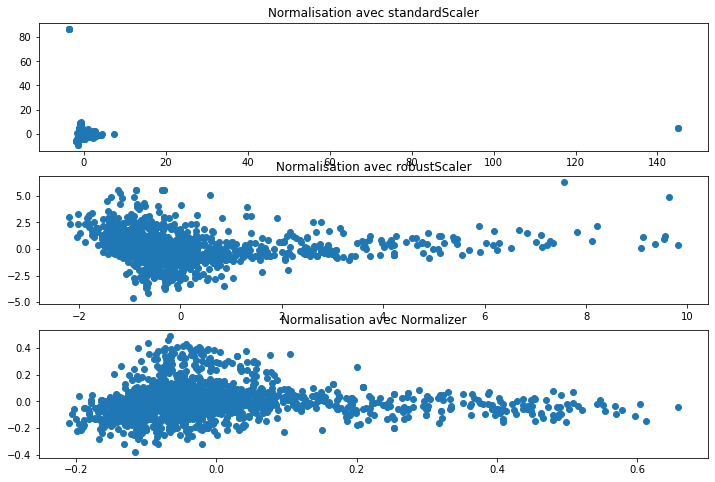

In [62]:
plt.figure(figsize=(12,8))   

plt.subplot(3,1,1)
plt.scatter(x=pca_stand[:,0] , y=pca_stand[:,1] )
plt.title('Normalisation avec standardScaler')

plt.subplot(3,1,2)
plt.scatter(x=pca_robust[:,0] , y=pca_robust[:,1] ) 
plt.title('Normalisation avec robustScaler')


plt.subplot(3,1,3)
plt.scatter(x=pca[:,0] , y=pca[:,1] ) 
plt.title('Normalisation avec Normalizer')


plt.show()

### Remarques:

Du resultat précédent on a remarqué qu'il y a des données qui sont complètement écrasées face aux  outliers ce qui peut enpecher d'avoir une meilleure representation des données et peut rendre nos données difficilement exploitable avec simplement un Standascaler(). 

Dans la figure 2  **"PCA robustScaler"**, n'est pas sensibles aux outliers. Il consiste à soustraire les données à la médiane et diviser par l'écart interqurtile, la médiane est moins sensible aux outliers que la moyenne.

Parcontre, on va utiliser **Normalizer** pour la suite de classifiaication puisqu'il fait une normalisation sur les lignes et il est mieux adapté pour la classification des texts (NLP) qui est notre cas.
***


***
#### TSNE
Notre dataset étant constitué d'un nombre important de variables une reduction avec TSNE est idéale. On verra ainsi sur le graphique suivant la différence de representation par rapport au PCA Normalizer précédemment. La classification qui sera constituée sera considérée sur les resultats du TSNE.
***

In [63]:
tsne = TSNE(n_components=3, metric='cosine', init='pca').fit_transform(df_tdm_norm)

Text(0.5, 1.0, 'Visualisation avec TSNE')

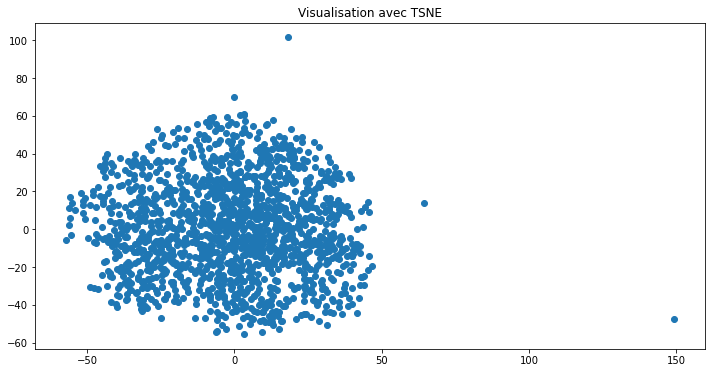

In [64]:
plt.figure(figsize=(12,6))   
plt.scatter(x=tsne[:,0] , y=tsne[:,1] )
plt.title('Visualisation avec TSNE')


***
### DBSCAN
- On va faire une premiere approche de classification avec l'algorithme DBSCAN. Cet algorithme va nous permettre de voir s'il y des lieux de réalisation de projets qui sont trop éloignés des autres (considérés comme anormalies).
    
    
- Pour avoir une meilleur visibilité sur les outiliers, on se servir le dataset avec la normalisation standartScaler
    

#### Determination d'epsilon

In [65]:
neigh = NearestNeighbors(n_neighbors=5) # on definit le nombre de voisin minimal à 2
nbrs = neigh.fit(df_tdm_stand)
distances, indices = nbrs.kneighbors(df_tdm_stand)

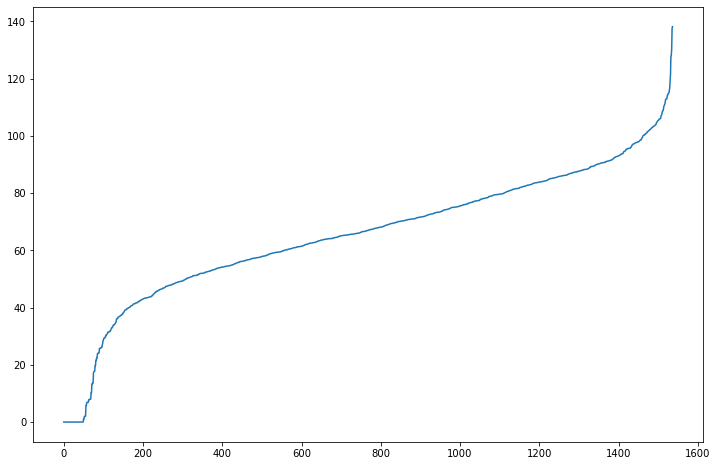

In [66]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(12,8))
plt.plot(distances)

Nous allons choisir un $\epsilon$ de tel sorte qu'on ait plus de 90% des observations aient une distance au proche voisin inférieure à $ \epsilon $. Ainsi on choisi $ \epsilon =100 $
***

#### Implémentation de l'algorithme

In [67]:
model= DBSCAN(eps=100, min_samples=2, metric='euclidean').fit(df_tdm_stand)
#model.labels_

In [68]:
# On separe les outliers des  data clusters
outliers_df=X[model.labels_ == -1]
clusters_df=X[model.labels_ != -1]
clusters_all=X[model.labels_]

colors=model.labels_

# On affiche  les infos sur nos clusters et ouliers
clusters=Counter(model.labels_)
n_clusters = len(set(model.labels_)) - (1 if -1 in model.labels_ else 0)
n_outliers=len(outliers_df)

print(clusters)
print("Nombre de clusters = {}".format(n_clusters))
print("Nombre de outliers = {}".format(n_outliers))

Counter({0: 1454, -1: 75, 1: 2, 2: 2, 3: 2, 4: 2})
Nombre de clusters = 5
Nombre de outliers = 75


On constate 75 outliers suivant notre classement avec DBSCAN, une quantité assez faible par rapport 1537 observations que contient notre dataset. On decide de garder les outliers pour la suite, cette quantité n'aura pas un trop grand effet sur la classifiacation.
***

In [70]:
# On reduit sur les 3 premieres composantes
db_reduce = TSNE(n_components=3).fit_transform(clusters_all)

In [71]:
# On visualise sur le premier plan
fig=px.scatter(x=db_reduce[:,0], y=db_reduce[:,1], color=colors)
fig.update_traces(textposition='top center')   
fig.show()

In [72]:
dbscan_clusters = pd.DataFrame({'pays/villes' : df_tdm_clean.index,
                            'clusters' : model.labels_})
dbscan_clusters.head()

pays/villes  clusters
0  Irbid et Ramtha        -1
1           Douala         0
2            Niger         0
3   Tahoua, Agadez         0
4             Lima         0

***
## Méthode de K-means
***

##### Methode du coude 


Pour determiner le nombre de clusters optimal onva utiliser la méthode du coude. 

In [73]:
distortions = []

K = range(4,20)

for k in K:
    kmeanModel = KMeans(n_clusters=k,random_state=0)
    kmeanModel.fit(df_tdm_norm)
    distortions.append(kmeanModel.inertia_)


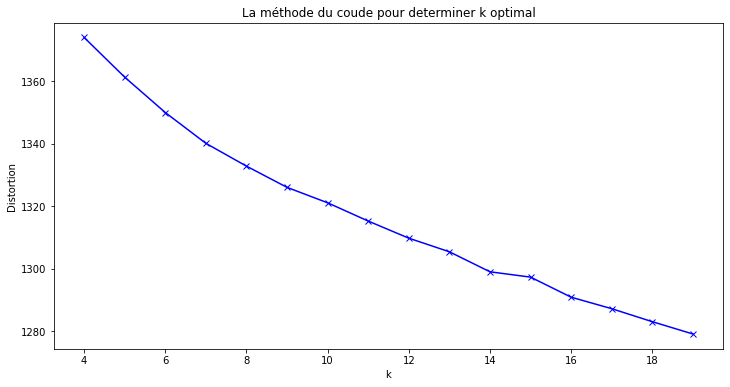

In [74]:
plt.figure(figsize=(12,6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('La méthode du coude pour determiner k optimal')
plt.show()

In [75]:
from sklearn.metrics import silhouette_score

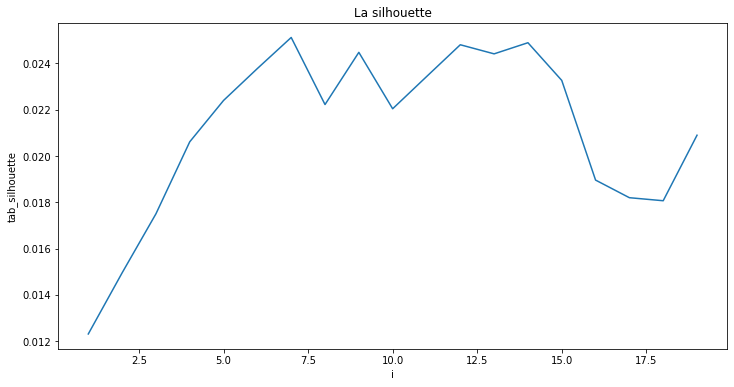

In [76]:
tab_silhouette=[]
for i in range(1,20):
    kmeans_2=KMeans(n_clusters=i+1, random_state=0).fit_predict(df_tdm_norm)
    tab_silhouette.append(silhouette_score(df_tdm_norm, kmeans_2))
    
plt.figure(figsize=(12,6))   
plt.plot(range(1,20), tab_silhouette)
plt.xlabel('i')
plt.ylabel('tab_silhouette')
plt.title('La silhouette')
plt.show()

**On conclut que le nombre de k optimal est 7**
***

##### On fait un classement pour k=7
- On fera une prediction sur les resultats du PCA et une autre sur les resultats du TSNE

In [79]:
 #Initiatilisaion de l'algorithme KMeans
kmeans = KMeans(n_clusters= 7, random_state=0)

In [81]:
#Prédiction sur le resultat du pca
label = kmeans.fit_predict(pca)
 
centroids = kmeans.cluster_centers_
u_labels = np.unique(label)


# Create an array with the colors you want to use
colors = ["#948ab4", "#ccc8ee","#cc7e9b", "#fbc7d6", "#aaa2a1","#cccccc","y","c"]

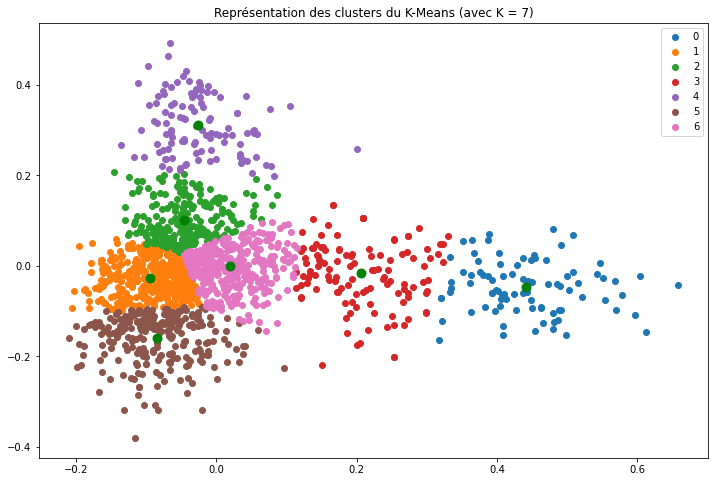

In [82]:
#Représentation graphique:
plt.figure(figsize=(12,8))

for i in u_labels:
    plt.scatter(pca[label == i , 0] , pca[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, alpha = 1, color = 'g')
plt.title('Représentation des clusters du K-Means (avec K = 7)')  
plt.legend()
plt.show()

In [83]:
#Prédiction sur le resultat du TSNE
label = kmeans.fit_predict(tsne)
 
centroids = kmeans.cluster_centers_
u_labels = np.unique(label)

# Create an array with the colors you want to use
colors = ["#948ab4", "#ccc8ee","#cc7e9b", "#fbc7d6", "#aaa2a1","#cccccc","y","c"]

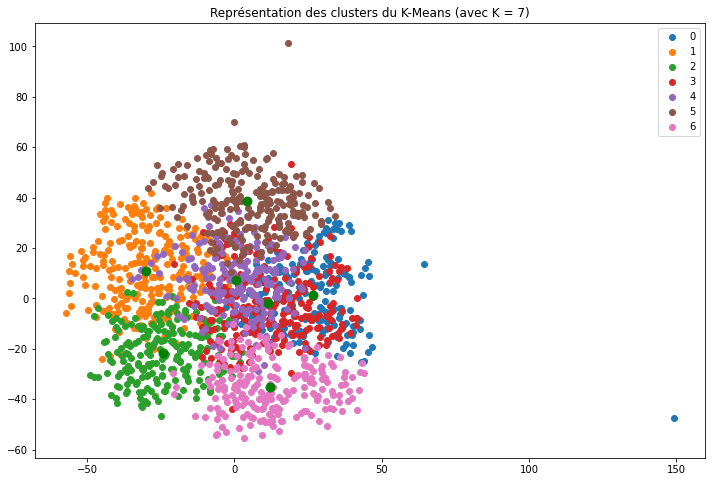

In [84]:
#Représentation graphique:
plt.figure(figsize=(12,8))

for i in u_labels:
    plt.scatter(tsne[label == i , 0] , tsne[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, alpha = 1, color = 'g')
plt.title('Représentation des clusters du K-Means (avec K = 7)')  
plt.legend()
plt.show()

***
On precise que le dataset suivant **"km_clusters"** sera construit sur les resultats de kmeans TSNE. 

In [85]:
km_clusters = pd.DataFrame({
                            'Titre_projet': data.title,
                            'cluster_km' : kmeans.labels_})
km_clusters.head()

Titre_projet  cluster_km
lieu                                                                          
Irbid et Ramtha  Un meilleur accès à l'eau pour les communautés...           4
Douala            Rénover l'axe de transport essentiel du Cameroun           5
Niger            AJUSEN : appui à la justice et à la sécurité a...           1
Tahoua, Agadez   Promouvoir le développement rural grâce à l'ag...           1
Lima             Développer un transport public efficace et dur...           5

In [86]:
# On classe les groupes de manière ordonnée
groupes= np.argsort(kmeans.labels_)

In [87]:
# La base de données classifiées
Data_classified = pd.DataFrame({
                            'Pays/Villes': df_tdm_clean.index[groupes],
                            'Groupes' : kmeans.labels_[groupes]})
Data_classified.head()

Pays/Villes  Groupes
0                                            Balbala        0
1                                       Massif d'Aïr        0
2                                             Nouméa        0
3  Liban : gouvernorats du Akkar, du Mont Liban, ...        0
4                                              Liban        0

## Apprentissage supervisé

Dans cette partie, on va utiliser les données tokenisées pour predire les classes crées à partir du kmeans. Cela nous permettera de valider la classification qui a été faite. C'est-à-dire si la prediction est mausvaise, il y a forte chance que la classification Kmeans a été mauvaise.

Pour faire cette prediction, on va jouer seulement sur les parametres des models dans l'étape preprocessing. On ne pourra pas jouer sur les variables du dataset puisqu'elles sont trop volumineuses.

In [88]:
df_sup = pd.DataFrame({'Titre_projet': data.title,
                        'cluster_km' : kmeans.labels_})

In [89]:
# On fait la concatenantion des deux dataset en reindexant df_tdm_clean
result = pd.concat([df_sup, df_tdm_clean], axis=1).reindex(df_tdm_clean.index)

In [90]:
# On eneleve la colone Titre_projet
df_result=result.drop(['Titre_projet'], axis=1)

In [91]:
# On separe le dataset en trainset et testset
trainset, testset = train_test_split(df_result, test_size=0.2, random_state=0)

In [92]:
trainset['cluster_km'].value_counts()

3    195
1    190
5    183
6    183
4    166
2    165
0    147
Name: cluster_km, dtype: int64

In [93]:
testset['cluster_km'].value_counts()

1    64
3    57
2    47
5    47
4    32
6    31
0    30
Name: cluster_km, dtype: int64

In [94]:
#On definit une fonction preprocessing pour separer la target "y" du dataset
def preprocessing(df_result):
    
    y = df_result['cluster_km']
    X = df_result.drop('cluster_km', axis=1)

    
    print(y.value_counts())
    
    return X, y

In [95]:
X_train, y_train = preprocessing(trainset)

3    195
1    190
5    183
6    183
4    166
2    165
0    147
Name: cluster_km, dtype: int64


In [96]:
X_test, y_test = preprocessing(testset)

1    64
3    57
2    47
5    47
4    32
6    31
0    30
Name: cluster_km, dtype: int64


In [97]:
from sklearn.model_selection import GridSearchCV

***
#### Procedure d'évaluation

On definit une fonction d'évaluation presentant les resultats sur le trainset et sur le testset. Dans cette fonction on fait intervenir la fonction lurning_curve qui va nous permettre de voir l'évolution de l'apprentisaage de la machine. Pour ce faire , on évalue le model sur plusieurs splits (autrement dit sur plusieurs lots du trainset) en commençant sur 10% des données jusqu'à 100%  en 15 lots. Et sur chaque lot on applique une cross-validation de 5 splits. La cross-validation permettera de limitter le surapprentissage.
***

In [174]:
# On definit une foncton d'évaluation
def evaluation(model):
    
   # Entrainement du model
    model.fit(X_train, y_train)
    ypred = model.predict(X_test)
    # score du model
    score=model.score(X_test, y_test)
    
    # On implémente la fonction lurning_curve
    N, train_score, val_score=learning_curve(model, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 15) , cv=5)
    # train_sizes: Indique un pourcentage de fin et un debut en 15 lots
    # N: prend la dimension de chaque tranche (chaque lot)
    # cv: cross_validation
    """ On rappelle que le "val_score" ce sera la validation qui sera éffectuée sur le 5e split du cv à chaque fois, 
    après avoir entrainé le model sur les 4 premiers splits."""


    
    print('Matricre de confudion')
    print(confusion_matrix(y_test, ypred))
    print()
    print(score)
    print()
    print('Rapport de classification:')
    print(classification_report(y_test, ypred))
    
    
    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='Validation')
    plt.xlabel('train_sizes')
    plt.legend()
    plt.show()   
    

***
#### Modelisation

On va definir un un dictionnaire de models regroupant plusieurs algorithme de predictions, chacun definit definit sur pipeline qui nous permettera de jouer sur les parametres de chaque model importé.

In [103]:
NaiveBayes = make_pipeline(GaussianNB())
RandomForest = make_pipeline(RandomForestClassifier(random_state=0))
AdaBoost = make_pipeline(AdaBoostClassifier(random_state=0))
SVM = make_pipeline(StandardScaler(), SVC(random_state=0))
KNN = make_pipeline(StandardScaler(), KNeighborsClassifier())

In [104]:
# On definit le dictionnaire contenant les différents algorithms
dict_of_models = {'RandomForest': RandomForest,
                  'NaiveBayes': NaiveBayes,
                  'AdaBoost' : AdaBoost,
                  'SVM': SVM,
                  'KNN': KNN
                 }

RandomForest
Matricre de confudion
[[10  4  1  6  1  3  5]
 [ 2 54  1  4  0  2  1]
 [ 2  2 39  0  1  0  3]
 [ 3  3  0 46  1  2  2]
 [ 0  4  0  1 25  2  0]
 [ 1  8  0  2  0 36  0]
 [ 0  0  0  2  0  0 29]]

0.775974025974026

Rapport de classification:
              precision    recall  f1-score   support

           0       0.56      0.33      0.42        30
           1       0.72      0.84      0.78        64
           2       0.95      0.83      0.89        47
           3       0.75      0.81      0.78        57
           4       0.89      0.78      0.83        32
           5       0.80      0.77      0.78        47
           6       0.72      0.94      0.82        31

    accuracy                           0.78       308
   macro avg       0.77      0.76      0.76       308
weighted avg       0.78      0.78      0.77       308



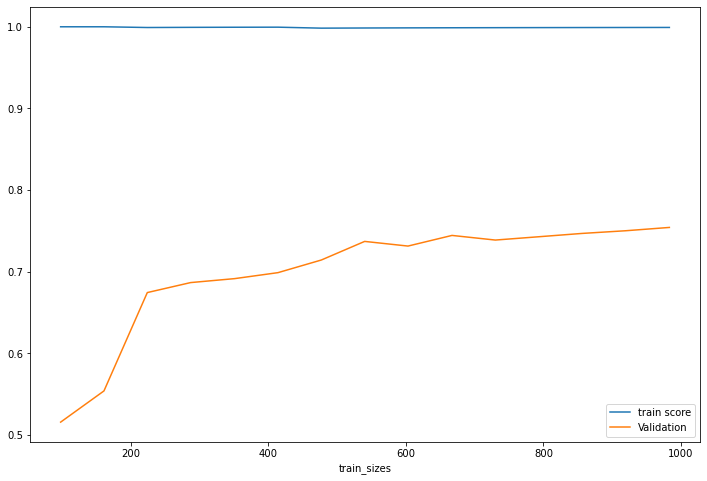

NaiveBayes
Matricre de confudion
[[10  2  0 12  1  3  2]
 [ 2 40  6  6  3  5  2]
 [ 1  7 29  0  1  6  3]
 [10  6  1 34  2  2  2]
 [ 2  5  2  0 22  1  0]
 [ 2  4  3  3  2 33  0]
 [ 1  0  1  8  0  1 20]]

0.6103896103896104

Rapport de classification:
              precision    recall  f1-score   support

           0       0.36      0.33      0.34        30
           1       0.62      0.62      0.62        64
           2       0.69      0.62      0.65        47
           3       0.54      0.60      0.57        57
           4       0.71      0.69      0.70        32
           5       0.65      0.70      0.67        47
           6       0.69      0.65      0.67        31

    accuracy                           0.61       308
   macro avg       0.61      0.60      0.60       308
weighted avg       0.61      0.61      0.61       308



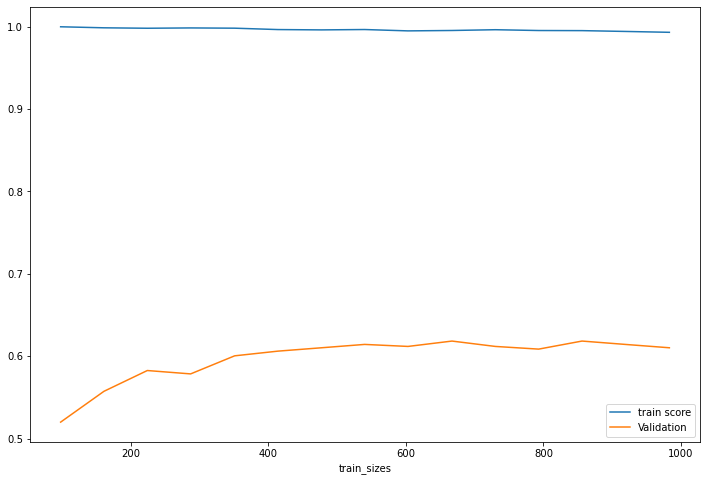

AdaBoost
Matricre de confudion
[[ 2  3  1  7  0 13  4]
 [ 3 29  6  5  3 17  1]
 [ 4  8 27  0  1  5  2]
 [ 7  3  0 34  1 12  0]
 [ 3  5  1  1 19  3  0]
 [ 4 11  1  4  1 26  0]
 [ 4  0  0  2  0  3 22]]

0.5162337662337663

Rapport de classification:
              precision    recall  f1-score   support

           0       0.07      0.07      0.07        30
           1       0.49      0.45      0.47        64
           2       0.75      0.57      0.65        47
           3       0.64      0.60      0.62        57
           4       0.76      0.59      0.67        32
           5       0.33      0.55      0.41        47
           6       0.76      0.71      0.73        31

    accuracy                           0.52       308
   macro avg       0.54      0.51      0.52       308
weighted avg       0.55      0.52      0.52       308



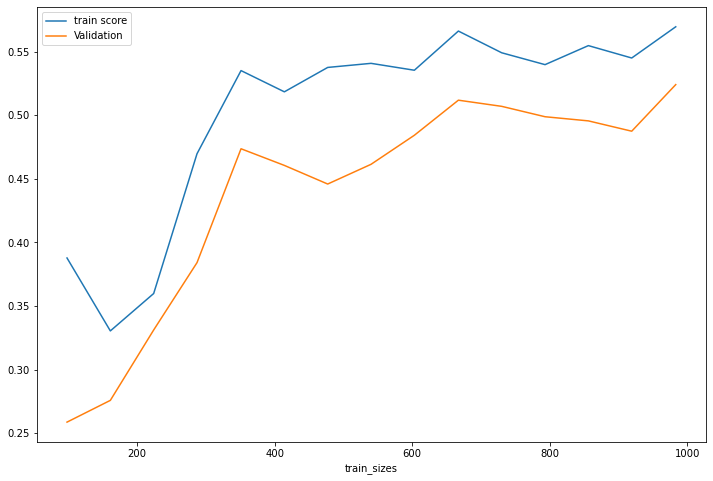

SVM
Matricre de confudion
[[ 3  6  0 13  2  4  2]
 [ 0 54  0  6  0  2  2]
 [ 0 17 25  2  0  3  0]
 [ 1  2  0 51  0  3  0]
 [ 0 11  0  1 19  1  0]
 [ 0 10  0  3  0 33  1]
 [ 0  3  0  6  0  0 22]]

0.672077922077922

Rapport de classification:
              precision    recall  f1-score   support

           0       0.75      0.10      0.18        30
           1       0.52      0.84      0.65        64
           2       1.00      0.53      0.69        47
           3       0.62      0.89      0.73        57
           4       0.90      0.59      0.72        32
           5       0.72      0.70      0.71        47
           6       0.81      0.71      0.76        31

    accuracy                           0.67       308
   macro avg       0.76      0.63      0.63       308
weighted avg       0.74      0.67      0.65       308



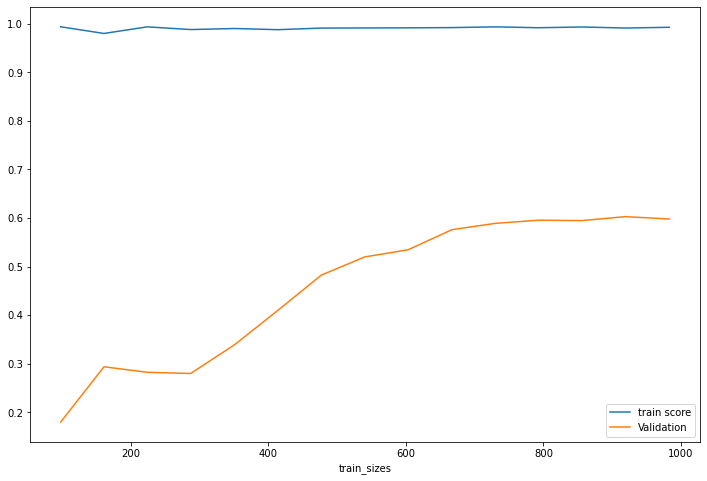

KNN
Matricre de confudion
[[24  0  0  0  1  3  2]
 [49  2  0  0  4  6  3]
 [30  0  4  0  2  4  7]
 [42  0  0  5  0  4  6]
 [19  0  0  0 11  2  0]
 [28  0  1  0  0 15  3]
 [16  0  0  0  0  1 14]]

0.2435064935064935

Rapport de classification:
              precision    recall  f1-score   support

           0       0.12      0.80      0.20        30
           1       1.00      0.03      0.06        64
           2       0.80      0.09      0.15        47
           3       1.00      0.09      0.16        57
           4       0.61      0.34      0.44        32
           5       0.43      0.32      0.37        47
           6       0.40      0.45      0.42        31

    accuracy                           0.24       308
   macro avg       0.62      0.30      0.26       308
weighted avg       0.70      0.24      0.23       308



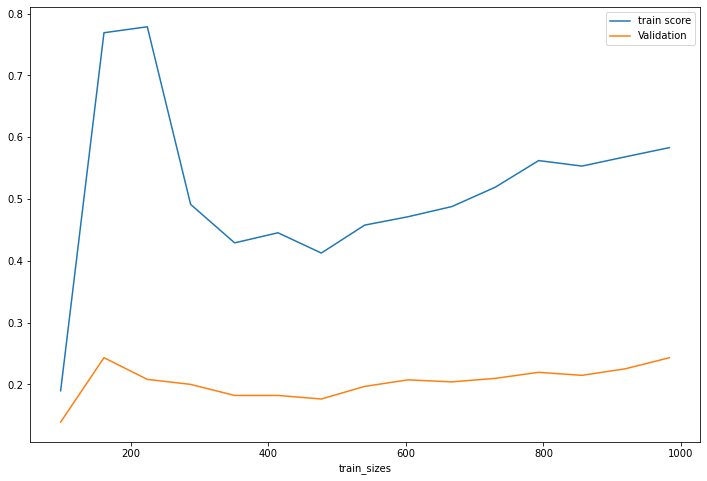

In [151]:
for name, model in dict_of_models.items():
    print(name)
    evaluation(model)

### Remarques:

1. Le RandomForest donne un accuracy de 78% qui est un resultat relativement acceptable et c'est le model donnant le meilleur résultat. On constate entre autre un écart considérable entre l'apprentissage de trainset (train_score) et celui du testset (val_score). Parcontre il y a évolution sur le "val_score" car la courbe est croissante, ce qui sous-entend que si on injecte plus de données au model , la courbe peut continuer à croitre.



2. Pour le model NaiveBayes qui est connu pour la classification des textes ne donne pas un bon résultat. On remarque la courbe d'apprentissage sur le val_score a tendence à redescendre. On peut supposer que la cause ce mauvais resultat est liée par le fait que le model "NaiveBayes" est éfficace lorsque les variables sont indepentantes, ce qui n'est pas forecement le cas ici puisque la quantité des variables est très volumineuse.


3. Pour "Adaboost", on n'a pas un meilleur resultat mais on peut remarquer l'apprentaissage est quasiment le même sur le train_score et sur le val_score donc , il n'y a pas de risque de surapprentissage car il n'y a pas de grand écart entre les deux courbes. C'est ce qui explique la robustesse du model Boosting (L'entrainement sur plusieurs échantillons de mannière séquentielle en ameliorant au fur et à mesure chaque model-echantionnal).


4. Pour SVM, le resultat est relativement pas mal avec un score de 67%. Peut-être avec plus de données on pourrait trouver mieux.


5. KKN est le model le moins adapté avec notre situation, on peut voir son resultat est très faible avec 24% de score. Même sur le trainset, le resultat est tres mauvais. 
***



#### Essai d'optimisation du resultat du model

On va essayer d'optimiser l'apprentissage avec RandomForest en jouant sur ses parametres pour voir si on peut trouver mieux. Pour ce faire, on va faire varier le nombre d'estimateurs "n_estimators" pour voir sur quelle valeur on obtient un meilleur resultat que celui précédemment.

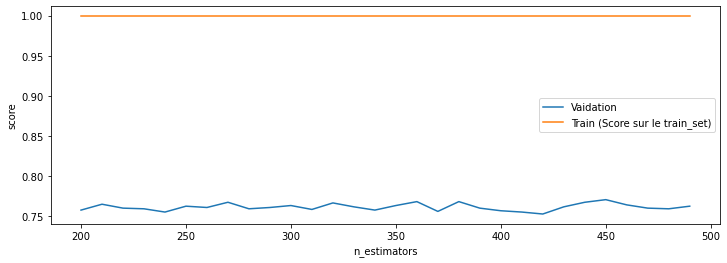

In [220]:
model = RandomForestClassifier()
k= np.arange(200, 500,10) 

train_score, val_score = validation_curve(model, X_train, y_train, 'n_estimators', k, cv=5)
# Qui donne tous les scores pour le trainset  et tous les secore pour le validation set

plt.figure(figsize=(12, 4))
plt.plot(k, val_score.mean(axis=1), label='Vaidation')
plt.plot(k, train_score.mean(axis=1), label='Train (Score sur le train_set)')

plt.ylabel('score')
plt.xlabel('n_estimators')
plt.legend()
plt.show()

On peut constater que le resultat reste toujours en-dessous de 80% , donc on ne peut pas trouver mieux par cette méthode.
***

### Nomination des classes

On va attribuer un nom à chaque classe. Pour ce faire, on analyser le titre de chaque projet et recuper les mots ou le groupes de mots qui se repetent le plus dans une classe. Et ainsi nommer la classe en fonction des ces mots.

In [221]:
# Les pays/villes appartenant a la même classe
classe_0=km_clusters.loc[km_clusters['cluster_km'] ==0]
classe_1=km_clusters.loc[km_clusters['cluster_km'] ==1]
classe_2=km_clusters.loc[km_clusters['cluster_km'] ==2]
classe_3=km_clusters.loc[km_clusters['cluster_km'] ==3]
classe_4=km_clusters.loc[km_clusters['cluster_km'] ==4]
classe_5=km_clusters.loc[km_clusters['cluster_km'] ==5]
classe_6=km_clusters.loc[km_clusters['cluster_km'] ==6]


In [222]:
# On oppelle la fonction desc_cleaning qui a été dejà définie plus haut
Titres_0=classe_0["Titre_projet"]
df_count_title_0=desc_cleaning(Titres_0)

In [223]:
# On place tous les titres de cette classe dans un tableau
tab01=[]
for i in range(len(df_count_title_0)):
    my_title_0= word_tokenize(df_count_title_0['Description'].iloc[i], language="french")
    tab01.append(my_title_0)    
    
tab02=[]
for i in range(len(tab01)):
    for j in range(len(tab01[i])):
        tab02.append(tab01[i][j])   

In [224]:
# On affiche les 20 premiers mots les plus communs
title_0_most_common = collections.Counter(tab02).most_common()

In [225]:
fig = px.bar(title_0_most_common, x=[pair[0] for pair in title_0_most_common][0:20], y= [pair[1] for pair in title_0_most_common][0:20])
fig.show()

La **classe_0** peut être nommée **"Santé"**, ces pays/villes ont eu besoin de supports pour renforcer et ameliorer l'accès à la santé.
***

In [226]:
Titres_1=classe_1["Titre_projet"]
df_count_title_1=desc_cleaning(Titres_1)

In [227]:
# On place tous les titres de cette classe dans un tableau
tab11=[]
for i in range(len(df_count_title_1)):
    my_title_1= word_tokenize(df_count_title_1['Description'].iloc[i], language="french")
    tab11.append(my_title_1)    
    
tab12=[]
for i in range(len(tab11)):
    for j in range(len(tab11[i])):
        tab12.append(tab11[i][j])   

In [228]:
# On collectes les mots les plus communs du tableau tab12
title_1_most_common = collections.Counter(tab12).most_common()
# On affiche les 20 premiers les plus communs
fig = px.bar(title_1_most_common, x=[pair[0] for pair in title_1_most_common][0:20], y= [pair[1] for pair in title_1_most_common][0:20])
fig.show()

La **classe_1** peut être nommée **"Developpement durable"** ces pays/villes ont eu des besoins dans le developpement durable. 
***

In [229]:
Titres_2=classe_2["Titre_projet"]
df_count_title_2=desc_cleaning(Titres_2)

In [230]:
# On place tous les titres de cette classe dans un tableau
tab21=[]
for i in range(len(df_count_title_2)):
    my_title_2= word_tokenize(df_count_title_2['Description'].iloc[i], language="french")
    tab21.append(my_title_2)    
    
tab22=[]
for i in range(len(tab21)):
    for j in range(len(tab21[i])):
        tab22.append(tab21[i][j])          

In [231]:
# On collectes les mots les plus communs du tableau tab22
title_2_most_common = collections.Counter(tab22).most_common()
# On affiche les 10 premiers les plus communs
fig = px.bar(title_2_most_common, x=[pair[0] for pair in title_2_most_common][0:20], y= [pair[1] for pair in title_2_most_common][0:20])
fig.show()

La classe_2 peut être nommée **"Developpement social"**, ce sont des pays/villes ayant bénéficié des supports dans le developpemnt de servces sociaux, ecole, projets communaux ou urbains.
***

In [232]:
Titres_3=classe_3["Titre_projet"]
df_count_title_3=desc_cleaning(Titres_3)

In [233]:
# On place tous les titres de cette classe dans un tableau
tab31=[]
for i in range(len(df_count_title_3)):
    my_title_3= word_tokenize(df_count_title_3['Description'].iloc[i], language="french")
    tab31.append(my_title_3)    
    
tab32=[]
for i in range(len(tab31)):
    for j in range(len(tab31[i])):
        tab32.append(tab31[i][j])          

In [234]:
# On collectes les mots les plus communs du tableau tab32
title_3_most_common = collections.Counter(tab32).most_common()
# On affiche les 10 premiers les plus communs
fig = px.bar(title_3_most_common, x=[pair[0] for pair in title_3_most_common][0:20], y= [pair[1] for pair in title_3_most_common][0:20])
fig.show()

La calsse_3 peut être nomée **"Developpement du secteur agricol"**, ces pays ont eu besoin dans le secteur agricol.
***

In [235]:
Titres_4=classe_4["Titre_projet"]
df_count_title_4=desc_cleaning(Titres_4)

In [236]:
# On place tous les titres de cette classe dans un tableau
tab41=[]
for i in range(len(df_count_title_4)):
    my_title_4= word_tokenize(df_count_title_4['Description'].iloc[i], language="french")
    tab41.append(my_title_4)    
    
tab42=[]
for i in range(len(tab41)):
    for j in range(len(tab41[i])):
        tab42.append(tab41[i][j])    

In [237]:
# On collectes les mots les plus communs du tableau tab42
title_4_most_common = collections.Counter(tab42).most_common()
# On affiche les 20 premiers les plus communs
fig = px.bar(title_4_most_common, x=[pair[0] for pair in title_4_most_common][0:20], y= [pair[1] for pair in title_4_most_common][0:20])
fig.show()

La classe_4 peut être nommée **"Electricité/ Energie renouvelapble"**. Ces pays ont eu des besoins au niveau d'électricité, des suppots pour construire de centres hydroélectirques.
***

In [238]:
Titres_5=classe_5["Titre_projet"]
df_count_title_5=desc_cleaning(Titres_5)

In [239]:
# On place tous les titres de cette classe dans un tableau
tab51=[]
for i in range(len(df_count_title_5)):
    my_title_5= word_tokenize(df_count_title_5['Description'].iloc[i], language="french")
    tab51.append(my_title_5)    
    
tab52=[]
for i in range(len(tab51)):
    for j in range(len(tab51[i])):
        tab52.append(tab51[i][j])   

In [240]:
# On collectes les mots les plus communs du tableau tab52
title_5_most_common = collections.Counter(tab52).most_common()
# On affiche les 20 premiers les plus communs
fig = px.bar(title_5_most_common, x=[pair[0] for pair in title_5_most_common][0:20], y= [pair[1] for pair in title_5_most_common][0:20])
fig.show()

La classe_5 peut être nommée **"Eau potable et assainissement"**, ces pays/villes ont eu besoin dans l'assainissement.
***

In [241]:
Titres_6=classe_6["Titre_projet"]
df_count_title_6=desc_cleaning(Titres_6)

In [242]:
# On place tous les titres de cette classe dans un tableau
tab61=[]
for i in range(len(df_count_title_6)):
    my_title_6= word_tokenize(df_count_title_6['Description'].iloc[i], language="french")
    tab61.append(my_title_6)    
    
tab62=[]
for i in range(len(tab61)):
    for j in range(len(tab61[i])):
        tab62.append(tab61[i][j]) 

In [243]:
# On collectes les mots les plus communs du tableau tab62
title_6_most_common = collections.Counter(tab62).most_common()
# On affiche les 20 premiers les plus communs
fig = px.bar(title_6_most_common, x=[pair[0] for pair in title_6_most_common][0:20], y= [pair[1] for pair in title_6_most_common][0:20])
fig.show()

La **classe_6** peut être nommée: **"Education et la fomation des jeunes"**. Ces pays/villes ont eu besoin dans la formation des jeunes pour leurs developpements.
***

In [244]:
# La base de données classifiée en fonction des besoins des pays/villes beneficiaires
Data_classified.loc[Data_classified['Groupes'] == 0, 'Groupes']='Santé'
Data_classified.loc[Data_classified['Groupes'] == 1, 'Groupes']='Developpement durable'
Data_classified.loc[Data_classified['Groupes'] == 2, 'Groupes']='Developpement social'
Data_classified.loc[Data_classified['Groupes'] == 3, 'Groupes']='Developpement du secteur agrico'
Data_classified.loc[Data_classified['Groupes'] == 4, 'Groupes']='Electricité/ Energie renouvelapble'
Data_classified.loc[Data_classified['Groupes'] == 5, 'Groupes']='Eau potable et assainissement'
Data_classified.loc[Data_classified['Groupes'] == 6, 'Groupes']='Education et la fomation des jeunes'

### Base de données finale

In [248]:
Data_classified.head()

Pays/Villes Groupes
0                                            Balbala   Santé
1                                       Massif d'Aïr   Santé
2                                             Nouméa   Santé
3  Liban : gouvernorats du Akkar, du Mont Liban, ...   Santé
4                                              Liban   Santé